<a href="https://colab.research.google.com/github/tanmayyb/screw-detector/blob/main/dataset_eda1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
import random
import json
import numpy as np
from skimage import io
from scipy import ndimage
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [44]:
# @title Choose device
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [45]:
device = set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


In [2]:
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
cd 'gdrive/My Drive/screw_dataset/unpacked/'

/content/gdrive/My Drive/screw_dataset/unpacked


In [5]:
#os.listdir()
#with open('README_v1.0.txt') as f: print(f.read())

## Data Loading

In [6]:
#Load the json file with the annotation metadata
with open('mvtec_screws.json') as f:
  data = json.load(f)

print(data.keys())
print(data['images'][0])
print(data['annotations'][0])

dict_keys(['categories', 'images', 'annotations', 'licenses', 'info'])
{'file_name': 'screws_001.png', 'height': 1440, 'width': 1920, 'id': 1, 'license': 1}
{'area': 3440.97, 'bbox': [184.5, 876.313, 55, 62.5631, 0], 'category_id': 7, 'id': 1001, 'image_id': 1, 'is_crowd': 0}


In [7]:
#Make a dictionary (imgdict), and attach image metadata by image ID
imgdict  = {l['id']:l for l in data['images']}

In [8]:
#@title function for adding to dict 
"""
#adding to dict
abc = {1:{'id':1,'di':2}, 2:{'id':1,'di':2}}
print(abc.values())

for i in abc.values():
  i['img'] = 1

print(abc.values())
"""

"\n#adding to dict\nabc = {1:{'id':1,'di':2}, 2:{'id':1,'di':2}}\nprint(abc.values())\n\nfor i in abc.values():\n  i['img'] = 1\n\nprint(abc.values())\n"

In [9]:
#attach images to imgdict that contains metadata
for i in imgdict.values():
  i['image'] = io.imread(os.path.join('images', i['file_name']))[:,:,:3]

In [10]:
#@title set up `annodict` annotation dict

# remap annotations to dict by image_id
from collections import defaultdict
annodict = defaultdict(list)
for annotation in data['annotations']:
  annodict[annotation['image_id']].append(annotation)

# setup list of categories
categories = data['categories']
ncategories = len(categories)
cat_ids = [i['id'] for i in categories]

In [11]:
category_names = {7:'nut', 3:'wood screw', 2:'lag wood screw', 8:'bolt',
                  6:'black oxide screw', 5:'shiny screw', 4:'short wood screw',
                  1:'long lag screw', 9:'large nut', 11:'nut', 10:'nut',
                  12:'machine screw', 13:'short machine screw' }

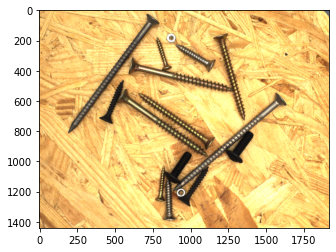

In [12]:
plt.imshow(imgdict[1]['image'][:,:])

## Checking out Data

In [13]:
from matplotlib import pyplot as plt
from matplotlib import rcParams, gridspec
from matplotlib import patches, transforms as plt_transforms

rcParams['figure.figsize'] = [16, 6]
rcParams['font.size'] =14
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [14]:
#@title subimage extractor functions 
def unpack_bbox(bbox):
  #bbox as in the json/COCO data format (centerx, centery, width, height, theta is in radians)

  rot_center = np.array((bbox[1], bbox[0])).T
  width = bbox[3]
  height = bbox[2]
  theta = -bbox[4]+np.pi/2 #radians
  return rot_center, width, height, theta

def extract_subimg_bbox(im, bbox):
  return extract_subimg(im, *unpack_bbox(bbox))

def extract_subimg(im, rot_center, width, height, theta):
  #rotates box
  rot_bbox = rotbbox_from_coords(rot_center, width, height, theta)

  subimg = im[rot_bbox[0,1]:rot_bbox[1,1],rot_bbox[0,0]:rot_bbox[1,0]]
  rotated_im = ndimage.rotate(subimg, np.degrees(theta)+180)
  newcenter = (np.array(rotated_im.shape)/2).astype(np.int)
  rotated_im = rotated_im[int(newcenter[0]-height/2):int(newcenter[0]+height/2), int(newcenter[1]-width/2):int(newcenter[1]+width/2), :3]  #drop alpha channel, if it's there

  return rotated_im


def rotcorners_from_coords(rot_center, width, height, theta):
  rotation = np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta))))

  wvec = np.dot(rotation, (width/2, 0))
  hvec = np.dot(rotation, (0, height/2))
  
  #obtains corner points after rotation
  corner_points = rot_center + [wvec+hvec, wvec-hvec, -wvec+hvec, -wvec-hvec]
  #                            [tr, br, tl, bl]
  
  return corner_points

def rotbbox_from_coords(rot_center, width, height, theta):
  corner_points = rotcorners_from_coords(rot_center, width, height, theta)
  rot_bbox = np.array((corner_points.min(0), corner_points.max(0))).astype(np.int)
  #constrain inside image
  rot_bbox[rot_bbox < 0] = 0

  return rot_bbox






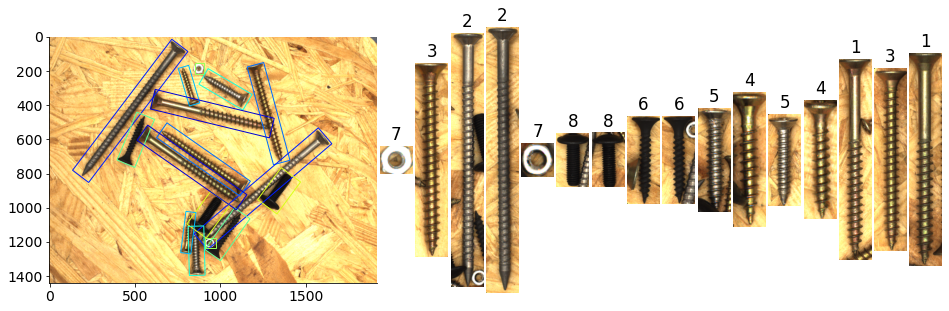

In [15]:
# Let's look at one image and it's associated annotations

imageid = 1
im = imgdict[imageid]['image']

gs = gridspec.GridSpec(1, 1 + len(annodict[imageid]),
                       width_ratios=[1,]+[.1]*len(annodict[imageid]),
                       wspace=.05)
plt.figure()
ax = plt.subplot(gs[0])
plt.imshow(im)
cmap_normal = plt.Normalize(0, ncategories) #dont know why this is here
#for color ^
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  fxn()

  for i, annotation in enumerate(annodict[imageid]):
    bbox = annotation['bbox'] # centerx, centery, width, height, theta is in radians

    ax = plt.subplot(gs[0])

    #sets the color of rectangle acc to category
    color = plt.cm.jet(cmap_normal(annotation['category_id']))


    #https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html


    #defines rectangular patch with bottom left as the anchor
    rect = patches.Rectangle((bbox[1] - bbox[3]/2 ,   # centery - height/2
                              bbox[0] - bbox[2]/2),   # centerx - width/2 
                              bbox[3],                # height
                              bbox[2],                # width
                            linewidth=1, edgecolor=color, facecolor='none')
    
    #rotates box around center of the image according to the 
    t = plt_transforms.Affine2D().rotate_around(  bbox[1],            # centery 
                                                  bbox[0],            # centerx
                                                  -bbox[4]+np.pi/2)   # -theta + pi/2
    
    #plot all the annotations on the side
    rect.set_transform(t + plt.gca().transData) #gca = get currect axis
    ax.add_patch(rect) #plots the boxes

    plt.subplot(gs[i + 1])# plot on the side 

    #extacts and plots rotated box patch image on the side
    rotated_im = extract_subimg_bbox(im, bbox)
    plt.imshow(rotated_im)
    
    plt.axis('off')
    plt.title(annotation['category_id'])


  plt.show()

In [16]:
# create a dict mapping category id to all subimages, can take some time to run
# this dictionary contains categorised sub images
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  fxn()
  cat_imgdict = defaultdict(list)
  for img_id, image in imgdict.items():
    for annotation in annodict[img_id]:
      bbox = annotation['bbox']
      subimg = extract_subimg_bbox(image['image'], bbox)
      cat_imgdict[annotation['category_id']].append(subimg.copy())

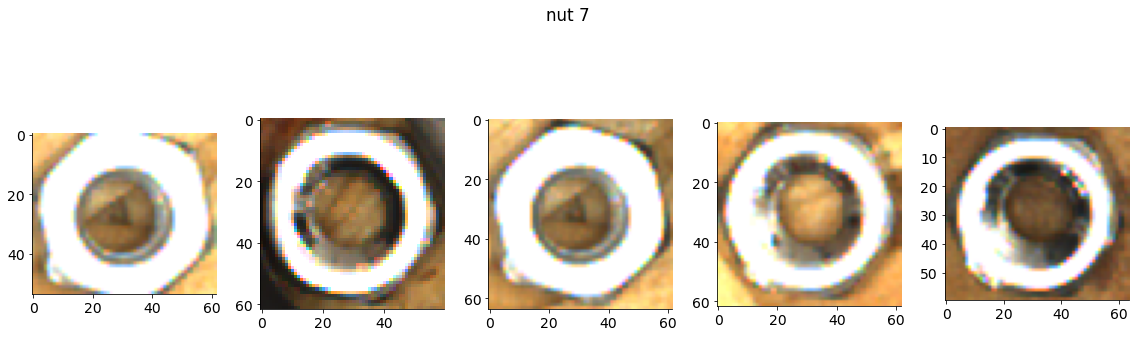

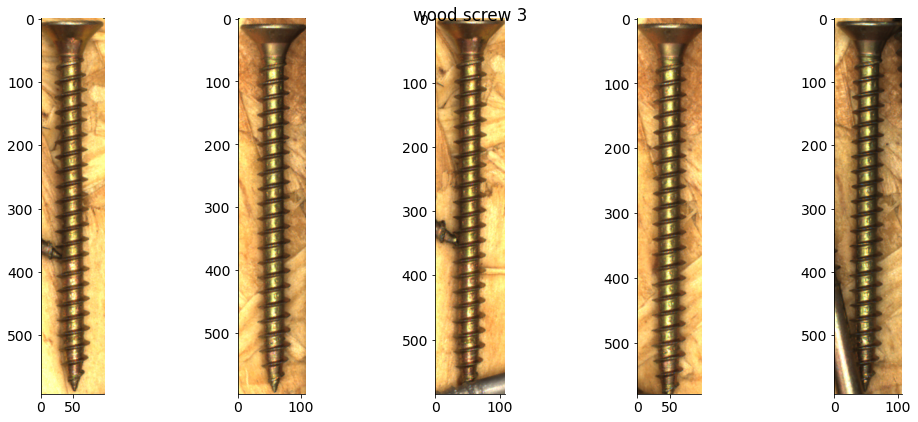

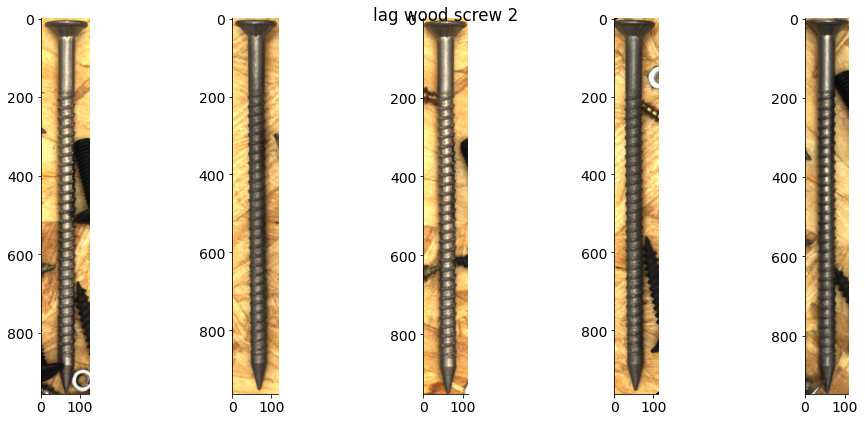

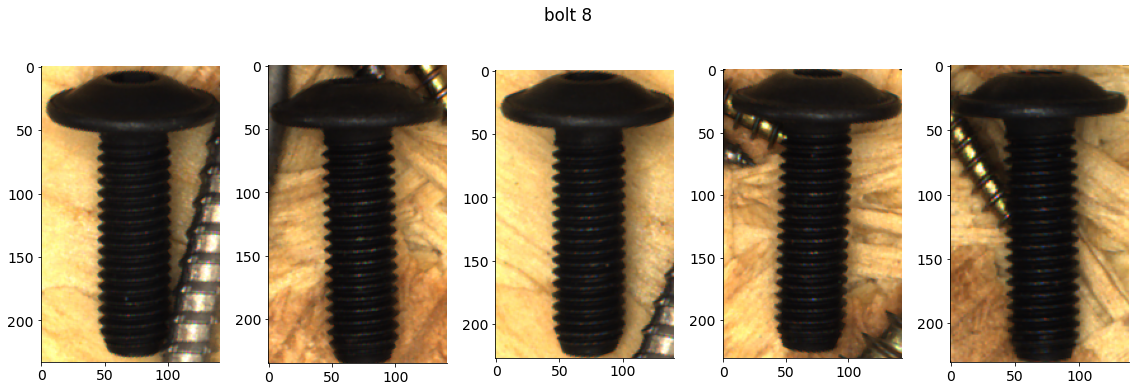

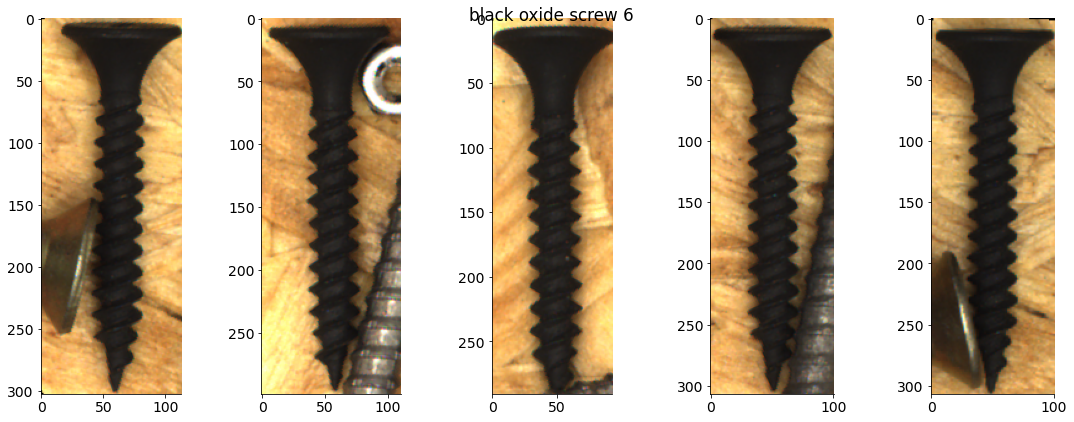

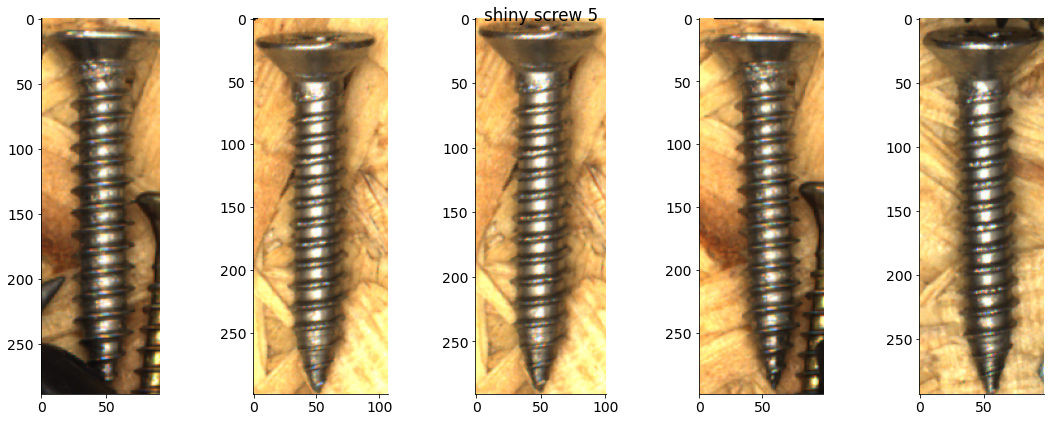

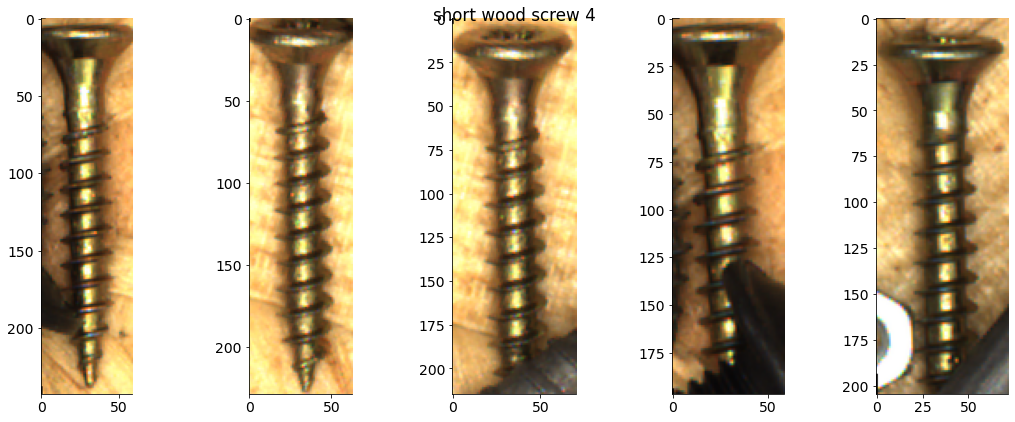

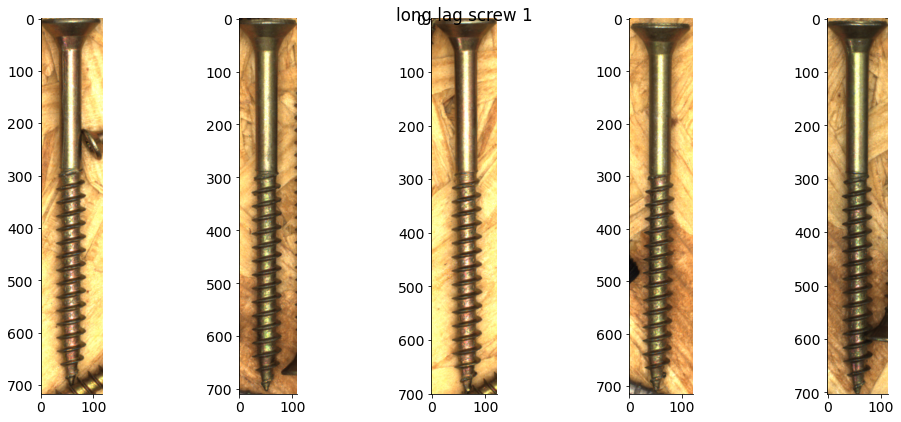

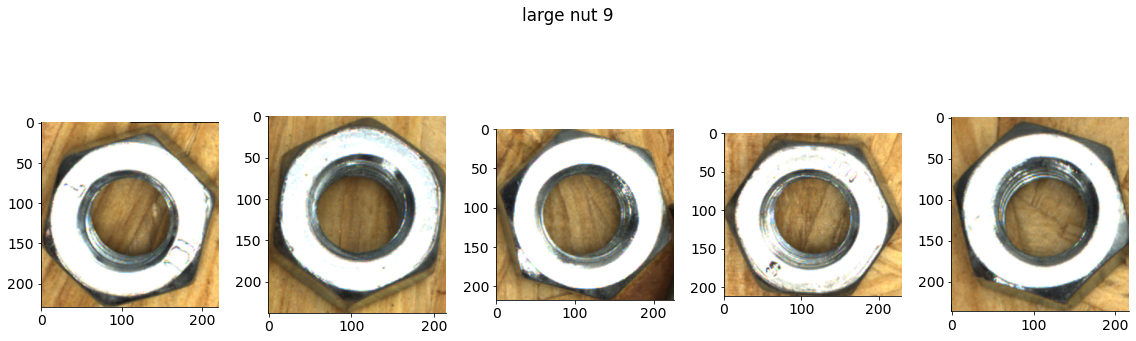

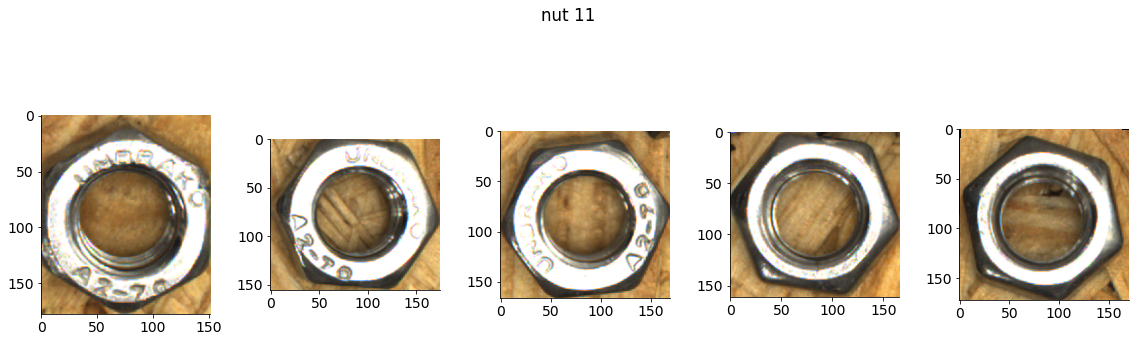

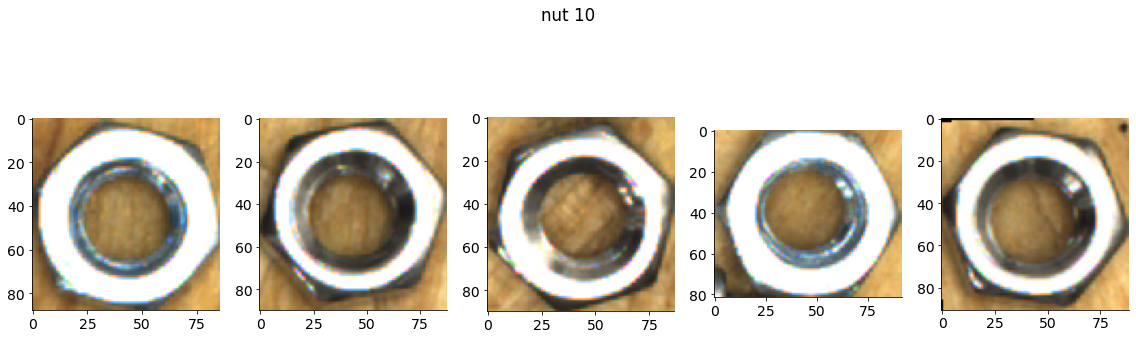

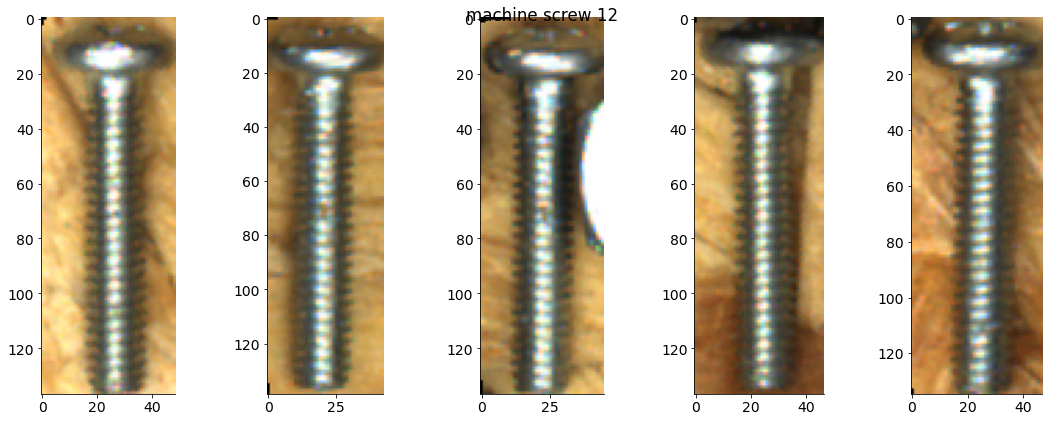

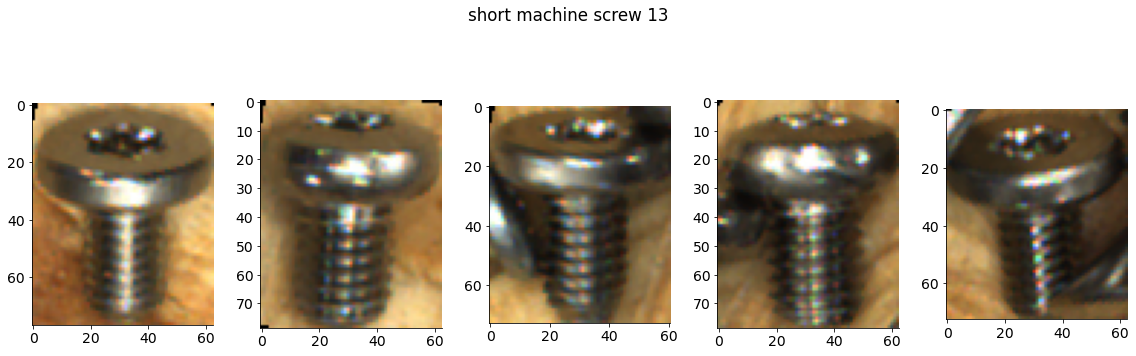

In [17]:
# Plot some examples from each category
for catid, examples in cat_imgdict.items():
  num_examples = 5
  gs = gridspec.GridSpec(1, num_examples)
  plt.figure()
  for i, example in enumerate(examples[:num_examples]):
    plt.subplot(gs[i])
    plt.imshow(example)
    plt.suptitle(f"{category_names[catid]} {catid}")

{'area': 59271.9, 'bbox': [449.1, 1282.24, 592.719, 100, -1.308127], 'category_id': 3, 'id': 1002, 'image_id': 1, 'is_crowd': 0}
[128 128]
dict_keys(['file_name', 'height', 'width', 'id', 'license', 'image'])


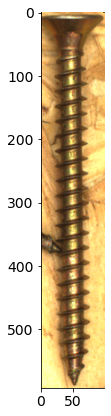

In [18]:
image = imgdict[1]
annotation1 = annodict[1][1] # first annotation in first image in the imgdict
patch_size = np.array((128,128))
print(annotation1)
print(patch_size)
print(image.keys())

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  fxn()
  
  rot_center, width, height, theta = unpack_bbox(annotation1['bbox'])
  subimg = extract_subimg(image['image'], rot_center, width, height, theta)
  #subimg = extract_subimg(image['image'], rot_center, patch_size[0], patch_size[0], 0)
  plt.imshow(subimg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


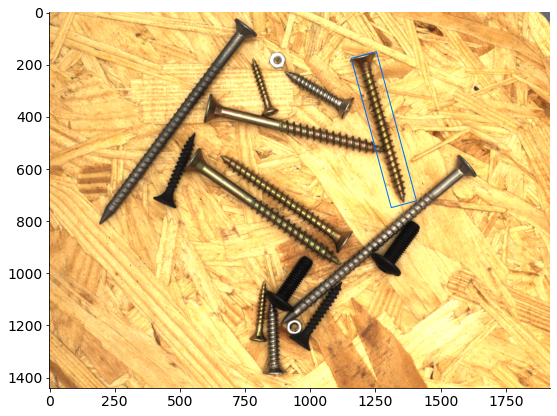

In [19]:
img_id = 1
ann_id = 1

#gs = gridspec.GridSpec(1, 1 + len(annodict[imageid]),
                    #   width_ratios=[1,]+[.1]*len(annodict[imageid]),
                     #  wspace=.05)
plt.figure()
ax = plt.subplot()
plt.imshow(imgdict[img_id]['image'])

bbox = annodict[img_id][ann_id]['bbox']

cmap_normal = plt.Normalize(0, ncategories)
color = plt.cm.jet(cmap_normal(annodict[img_id][ann_id]['category_id']))

rect = patches.Rectangle((bbox[1] - bbox[3]/2 ,   # centery - height/2
                            bbox[0] - bbox[2]/2),   # centerx - width/2 
                            bbox[3],                # height
                            bbox[2],                # width
                           linewidth=1, edgecolor=color, facecolor='none')  
#rotates box around center of the image according to the 
t = plt_transforms.Affine2D().rotate_around(  bbox[1],            # centery 
                                              bbox[0],            # centerx
                                              -bbox[4]+np.pi/2)   # -theta + pi/2
  
rect.set_transform(t + plt.gca().transData) #gca = get currect axis
ax = plt.subplot()

ax.add_patch(rect) #plots the annotation boxe

plt.show()

## Object Classification

### Get Patches

In [20]:
#@title get nut patches
use_categories = [7, 10]

patch_size = np.array((128,128))
num_patches_per_category = 500

nut_patches = []
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  fxn()
  for img_id, image in imgdict.items():
    for annotation in annodict[img_id]:
      
      if annotation['category_id'] in use_categories:
        bbox = annotation['bbox']
        rot_center, width, height, theta = unpack_bbox(bbox)
        subimg = extract_subimg(image['image'], rot_center, patch_size[0], patch_size[1], 0)
        
        if all(subimg.shape[:2] == patch_size):
          nut_patches.append(subimg)
          #plt.figure()
          #plt.imshow(subimg)

    if len(nut_patches) >= num_patches_per_category:
      break

In [21]:
#@title get random blank patches
#Select random blank patches
blank_patches = []
for i in range(len(nut_patches)):
  while True: #until a suitable random patch is found
    #choose random image
    imgid, imgobj = random.choice(list(imgdict.items()))
    im = imgobj['image']
    #choose random place at least half a patch size from edges
    rand_center = np.random.randint((patch_size//2), np.array(im.shape)[:2] - patch_size//2)
    corners = rotcorners_from_coords(rand_center, patch_size[0], patch_size[1], 0)
    #check if the random patch intersects with any labeled objects
    if not any([Polygon(corners).intersects(Polygon(rotcorners_from_coords(*unpack_bbox(annotation['bbox'])))) for annotation in annodict[imgid]]):
      rand_patch = im[rand_center[0]-patch_size[0]//2:rand_center[0]+patch_size[0]//2, rand_center[1]-patch_size[1]//2:rand_center[1]+patch_size[1]//2]
      blank_patches.append(rand_patch)
      break

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


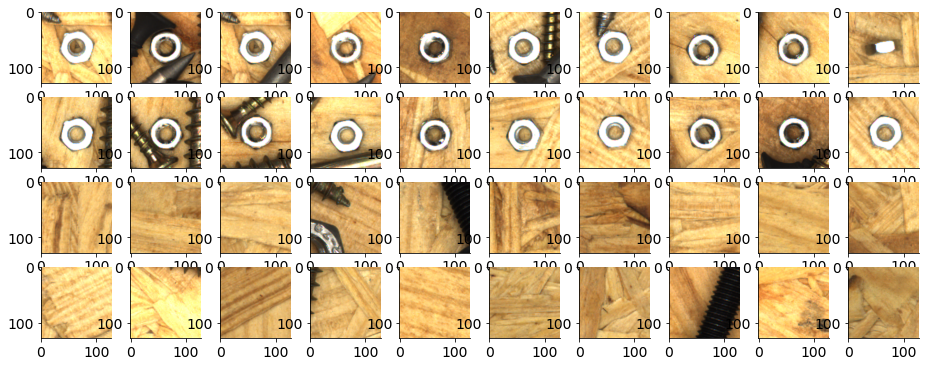

In [22]:
#@title visualize nut and blank patches
plt.figure()
num_examples = 10
gs = gridspec.GridSpec(4, num_examples, wspace=.05)
for j in range(2):
  for i in range(num_examples):
    plt.subplot(gs[j, i])
    plt.imshow(nut_patches[i+j*10])
for j in range(2):
  for i in range(num_examples):
    plt.subplot(gs[j+2, i])
    plt.imshow(blank_patches[i+j*10])

In [34]:
patch_labels = [1,]*len(nut_patches) + [0,]*len(blank_patches)  #1 if nut
all_patches = nut_patches + blank_patches #list concat

# randomly shuffle
shuffle_idx = np.random.choice(len(patch_labels), len(patch_labels), replace=False)
patch_labels = [patch_labels[i] for i in shuffle_idx]
all_patches = [all_patches[i] for i in shuffle_idx]

# Check shapes are correct
# assert all([p.shape == (128,128,3) for p in all_patches])
[i for i,p in enumerate(all_patches) if p.shape != (128, 128, 3)]

[]

### Preprocessing 

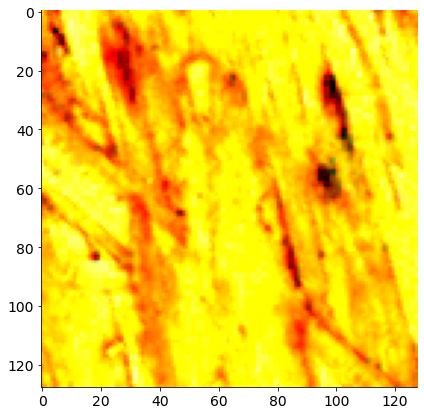

In [35]:
# Preprocess data
preprocess = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_frac = .2
train_number = int(len(all_patches)*train_frac)
# test_nuumber = all_patches.len()-train_number
train_patches, train_labels = all_patches[:train_number], patch_labels[:train_number]
test_patches, test_labels = all_patches[train_number:], patch_labels[train_number:]

plt.figure()
plt.imshow(preprocess(all_patches[0]).permute(1, 2, 0))
plt.show()

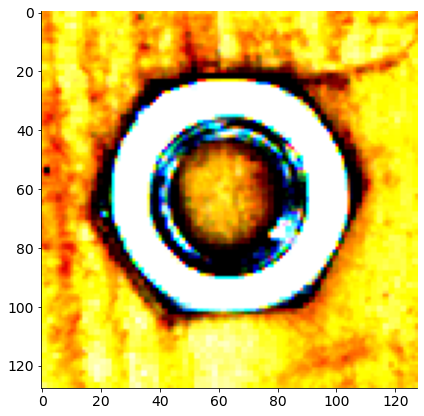

In [41]:
plt.imshow(preprocess(all_patches[100]).permute(1, 2, 0))

### Simple Network

In [ ]:
class SimpleScrewNet(nn.Module):
  def __init__(self):
    super().__init__()

    LeakyReLU = nn.LeakyReLU()
    MaxPool2d = nn.MaxPool2d(2, stride=2)
    self.layers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=7, stride=2),
        LeakyReLU,
        MaxPool2d,

        nn.Conv2d(16, 32, kernel_size=5),
        # nn.Conv2d(32, 32, kernel_size=5),
        LeakyReLU,
        MaxPool2d,

        nn.Conv2d(32, 64, kernel_size=5),
        LeakyReLU,
        MaxPool2d,

        nn.Flatten(1),

        nn.Linear(1024, 64),
        # nn.Dropout(),
        nn.Linear(64, 2),

        # nn.Conv2d(3, 6, 5),
        # nn.MaxPool2d(2, 2),
        # nn.Conv2d(6, 16, 5),
        # nn.Linear(16 * 5 * 5, 120),
        # nn.Linear(120, 84),
        # nn.Linear(84, 2),

    )

  def forward(self, x):
    # Simply pass the data through the layers
    return self.layers(x)

In [79]:
class SimpleScrewNet(nn.Module):
  def __init__(self):
    super().__init__()

    LeakyReLU = nn.LeakyReLU()
    MaxPool2d = nn.MaxPool2d(2, stride = 2)
    self.layers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 7, stride = 2),
        LeakyReLU,
        MaxPool2d,

        nn.Conv2d(16,32,kernel_size = 5),
        # nn.Conv2d(32, 32, kernel_size=5),
        LeakyReLU,
        MaxPool2d,

        nn.Conv2d(32,64,kernel_size = 5),
        LeakyReLU,
        MaxPool2d,


        nn.Flatten(1),

        nn.Linear(1024,64),
        # nn.Dropout(),
        nn.Linear(64,2),

        # nn.Conv2d(3, 6, 5),
        # nn.MaxPool2d(2, 2),
        # nn.Conv2d(6, 16, 5),
        # nn.Linear(16 * 5 * 5, 120),
        # nn.Linear(120, 84),
        # nn.Linear(84, 2),
    )

  def forward(self, x):
    # Pass data through the layers
    return self.layers(x)

In [80]:
# Inspect model structure and layer sizes
snet = SimpleScrewNet().to(device)
summary(snet, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 61, 61]           2,368
         LeakyReLU-2           [-1, 16, 61, 61]               0
         MaxPool2d-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 32, 26, 26]          12,832
         LeakyReLU-5           [-1, 32, 26, 26]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7             [-1, 64, 9, 9]          51,264
         LeakyReLU-8             [-1, 64, 9, 9]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                   [-1, 64]          65,600
           Linear-12                    [-1, 2]             130
Total params: 132,194
Trainable params: 132,194
Non-trainable params: 0
-------------------------------

In [81]:
# Loss
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(snet.parameters(),lr=0.000001,momentum=0.3)

#### Training

In [82]:
# Train
num_epoch = 5
train_losses= []  # loss per epoch
test_losses= []  # loss per epoch
test_corrects = []  # % correct per epoch

test_correct = []
with torch.no_grad():
  for img,lbl in zip(test_patches, test_labels):
    img=torch.from_numpy(img).float().permute(2,1,0).unsqueeze(0).cuda()
    lbl=torch.torch.as_tensor(lbl).unsqueeze(0).cuda()
    predict=snet(img)
    test_correct.append((predict.argmax() == lbl).item())
test_correct = np.array(test_correct)
print(f'Before starting: {test_correct.mean()*100:.2f}% of test images correct')

for epoch in range(num_epoch):
  train_loss=0.0
  test_loss=0.0
  test_correct = []

  snet.train()
  # for img,lbl in train_ds_loader:
  for img,lbl in zip(train_patches, train_labels):
    img=torch.from_numpy(img).float().permute(2,1,0).unsqueeze(0).cuda()
    lbl=torch.torch.as_tensor(lbl).unsqueeze(0).cuda()

    optimizer.zero_grad()
    # print(img.shape)
    predict=snet(img)
    loss=loss_fn(predict,lbl)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()*img.size(0)

  with torch.no_grad():
    for img,lbl in zip(test_patches, test_labels):
      img=torch.from_numpy(img).float().permute(2,1,0).unsqueeze(0).cuda()
      lbl=torch.torch.as_tensor(lbl).unsqueeze(0).cuda()
      predict=snet(img)
      loss=loss_fn(predict,lbl)
      test_loss+=loss.item()*img.size(0)
      test_correct.append((predict.argmax() == lbl).item())

  test_correct = np.array(test_correct).mean()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_corrects.append(test_correct)
  print('Epoch:{} Train Loss:{:.3f} Test Losss:{:.3f} Percent correct: {:.2f}%'.format(epoch,train_loss,test_loss, test_correct*100))

Before starting: 51.00% of test images correct
Epoch:0 Train Loss:88.103 Test Losss:180.832 Percent correct: 96.01%
Epoch:1 Train Loss:39.238 Test Losss:152.398 Percent correct: 96.76%
Epoch:2 Train Loss:32.776 Test Losss:133.602 Percent correct: 97.26%
Epoch:3 Train Loss:28.316 Test Losss:119.911 Percent correct: 97.63%
Epoch:4 Train Loss:25.042 Test Losss:109.525 Percent correct: 98.00%


In [83]:
# calculate percentage correct
correct = []
with torch.no_grad():
  for img,lbl in zip(test_patches, test_labels):
    img=torch.from_numpy(img).float().permute(2,1,0).unsqueeze(0).to(device)
    lbl=torch.torch.as_tensor(lbl).unsqueeze(0).to(device)
    predict=snet(img)
    correct += [(predict.argmax() == lbl).item()]
correct = np.array(correct)
print(f'{correct.mean():.3f}% of test images correct')

0.980% of test images correct


Text(0, 0.5, 'Loss')

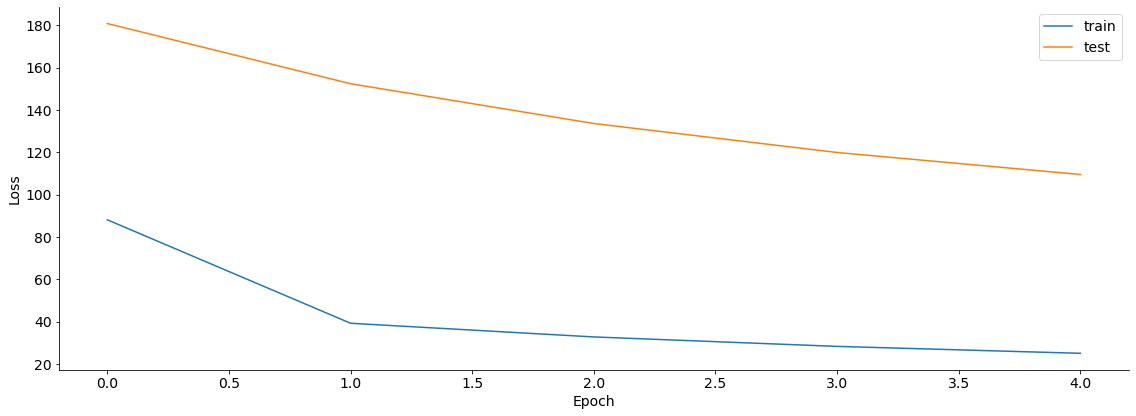

In [84]:
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')